In [1]:
from tqdm import tqdm

from utils import Data

data_csv = Data(
    fGEP_SGA = 'data/CITRUS_GEP_SGAseparated.csv',
    fgene_tf_SGA = 'data/CITRUS_gene_tf_SGAseparated.csv',
    fcancerType_SGA = 'data/CITRUS_canType_SGAseparated.csv',
    fSGA_SGA = 'data/CITRUS_SGA_SGAseparated.csv',
)

In [2]:
import pickle
import pandas as pd 
import os
from scipy.stats import ttest_ind
import argparse
import numpy as np

In [3]:
import os
import argparse
from utils import bool_ext, load_dataset, split_dataset, evaluate, checkCorrelations
from models import CITRUS
import pickle
import torch
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings("ignore") ##This is bad but temporary
import yaml 
from pathlib import Path

device = 'cuda' if torch.cuda.is_available() else 'cpu'
with open('args.yaml', 'r') as f:
    args_dict = yaml.safe_load(f)
    
tf_gene = np.load('tf_gene.npy')
    
parser = argparse.ArgumentParser()
args = argparse.Namespace(**args_dict)
args.tf_gene = tf_gene
    

dataset, dataset_test = load_dataset(
    input_dir=args.input_dir,
    mask01=args.mask01,
    dataset_name=args.dataset_name,
    gep_normalization=args.gep_normalization,
)

train_set, test_set = split_dataset(dataset, ratio=0.66)

daata = pickle.load( open("/ihome/hosmanbeyoglu/kor11/tools/CITRUS/data/dataset_CITRUS.pkl", "rb") )
cancers = daata['idx2can']


models = []
for m in Path('./output').iterdir():
    model = CITRUS(args) 
    model.build(device=device)
    model.to(device);
    model.load_model(m, device=device)
    model.eval()
    models.append(model)

FileNotFoundError: [Errno 2] No such file or directory: 'output'

In [6]:
def generateTFactivity(tf, idx2can, tmr, cans, tf_name):
    # generate the TF activity matrix
    df_TF = pd.DataFrame(data = tf, columns = tf_name, index = tmr)
    can_names = [idx2can[idx] for idx in cans]
    df_TF["cancer_type"] = can_names
    return(df_TF)

In [20]:
tf_2d = []
pathway_2d = []

for m in tqdm(models[:4]):
    preds, tf, hid_tmr, emb_tmr, emb_sga, attn_wt  = model.forward(torch.tensor(dataset['sga']), torch.from_numpy(dataset['can']))
    tf_2d.append(tf.detach().numpy())
    pathway = model.forward(torch.tensor(dataset['sga']), torch.from_numpy(dataset['can']), pathways=True)
    pathway_2d.append(pathway.detach().numpy())

    del preds, tf, hid_tmr, emb_tmr, emb_sga, attn_wt, pathway

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [7]:
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
np.array(tf_2d).shape, np.array(pathway_2d).shape

((4, 4642, 320), (4, 4642, 50))

In [19]:
tf_2d = np.array(tf_2d).mean(0)
pathway_2d = np.array(pathway_2d).mean(0)

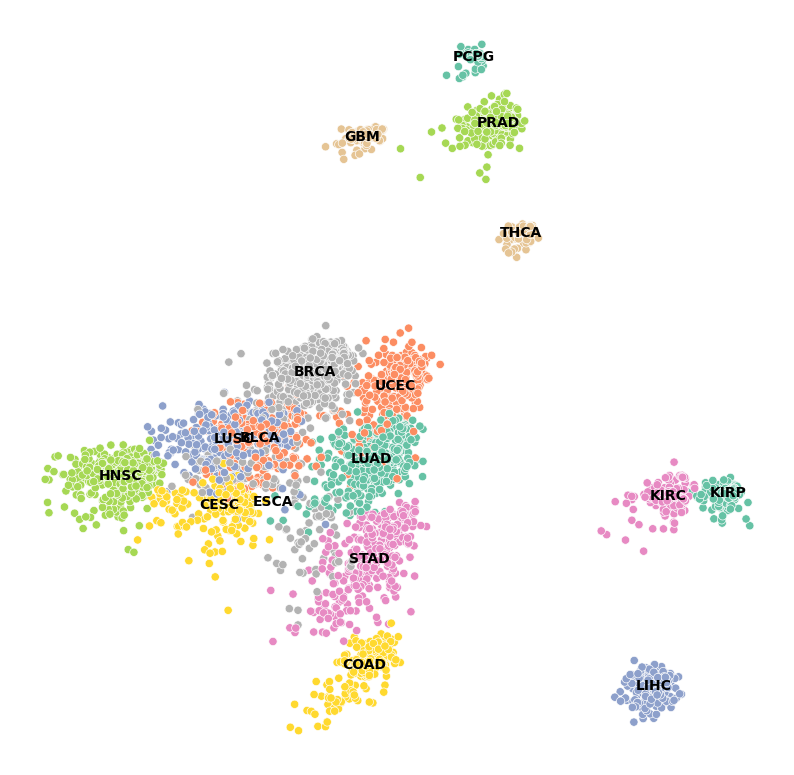

In [32]:
pca = PCA(n_components=2)
x = pathway_2d

d = data_csv.cancerType_sga.loc[dataset['tmr']]
d['index'] = dataset['can'].reshape(-1)

pca.fit(x)
pca.explained_variance_ratio_
dff = pd.DataFrame(pca.transform(x))
dff.columns = ['PC1', 'PC2']
dff['cancer'] = d.loc[dataset['tmr']]['type'].values


fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

sns.scatterplot(data=dff, x='PC1', y='PC2', hue='cancer', ax=ax, palette='Set2')

for r in dff.groupby('cancer').mean().iterrows():
    label = r[0]
    if label != 'BRCA' or label == 'BRCA':
        ax.annotate(r[0], 
                (r[1].PC1, r[1].PC2),
                horizontalalignment='center',
                verticalalignment='center',
                size=10, weight='bold',)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

ax.get_legend().remove()
plt.axis('off')
# plt.title('Pathways PCA Decomposition')
plt.savefig('pathways.svg', format='svg', dpi=1200)
plt.show()

In [4]:
run = list()

for d in tqdm(list(Path('/ix/hosmanbeyoglu/kor11/CITRUS_PKL').glob('*.pkl'))):
    dataset = pickle.load( open(d, "rb") )
    run.append(dataset) 
    
tfs = list()
for i in range(len(run)):
    tfs.append(run[i]["hid_tmr"])

100%|██████████| 13/13 [00:38<00:00,  2.93s/it]


In [7]:
tf_ensemble = 0
for i in range(len(run)):
    tf_ensemble += tfs[i]
    
tf_ensemble = tf_ensemble/len(run)

df_tf = generateTFactivity(tf_ensemble, daata["idx2can"],daata["tmr"], daata["can"], daata["tf_name"])


In [8]:
from scipy.stats import ttest_ind as ttest

In [9]:
df = pd.DataFrame(np.column_stack([daata['tmr'], daata['can']]), columns=['tmr', 'cancer'])
df['cancer'] = df['cancer'].astype(int).replace(daata['idx2can'])

def split_mutants(cancer, gene):    
    _sm = f'SM_{gene}'
    _scna = f'SCNA_{gene}'
    
    dframe = data_csv.sga_sga.loc[df[df.cancer==cancer].tmr]
    
    wt = dframe[(dframe[_sm] == 0) & (dframe[_scna] == 0)]
    sm = dframe[(dframe[_sm] == 1) & (dframe[_scna] == 0)]
    scna = dframe[(dframe[_sm] == 0) & (dframe[_scna] == 1)]
    sm_scna = dframe[(dframe[_sm] == 1) & (dframe[_scna] == 1)]
    
    return wt.index.values, sm.index.values, scna.index.values, sm_scna.index.values

In [10]:
import warnings 
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [20]:
df_tf[df_tf.cancer_type=='BRCA']

,CDC5L,PPARG,HOXB8,NFATC1,OVOL1,ZNF219,TBX1,NFATC2,BHLHA15,SOX4,...,E2F5,PAX6,ATF7,IRF4,HMBOX1,FUBP1,ZNF740,CEBPZ,DDIT3,cancer_type
TCGA-EW-A1IX,0.724059,-0.345777,0.533876,0.274598,-0.216675,0.741299,-0.191870,0.073369,0.504060,0.265650,...,-0.442598,-0.731769,0.216854,0.381547,0.195883,0.415247,0.845829,-0.321920,0.239764,BRCA
TCGA-A2-A0D3,0.799076,-0.363978,0.474229,0.131638,-0.288875,0.845225,-0.139799,0.072042,0.416422,0.109785,...,-0.577534,-0.776019,0.209670,0.310812,0.326084,0.297525,1.112511,-0.413679,0.163640,BRCA
TCGA-BH-A0BF,0.630442,-0.342871,0.442607,0.217076,-0.271857,0.778734,-0.249646,0.012957,0.550132,0.130122,...,-0.413839,-0.663965,0.223625,0.286649,0.075163,0.426995,0.716764,-0.324654,0.294979,BRCA
TCGA-C8-A1HJ,0.316574,-0.611317,0.094221,0.019382,-0.215554,1.021958,-0.003361,-0.106718,0.578056,0.457875,...,-0.096140,-0.556799,0.159318,0.214532,0.211188,0.974130,0.667016,-0.041272,0.340927,BRCA
TCGA-AR-A0TW,0.621495,-0.385567,0.295777,0.201740,-0.294825,1.282272,-0.020725,0.088449,0.377462,0.004710,...,-0.375155,-0.717200,0.223117,0.317477,0.190096,0.739546,0.951125,-0.282254,0.208477,BRCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A7-A26H,0.638325,-0.440274,0.358625,0.185809,-0.352990,1.380663,-0.157253,0.148165,0.551628,0.032013,...,-0.373554,-0.590118,0.106041,0.309127,0.226812,0.810398,0.806068,-0.370461,0.178743,BRCA
TCGA-AC-A8OR,0.529161,-0.265350,0.336692,0.082009,-0.184504,0.623915,-0.079366,0.020346,0.347692,0.300064,...,-0.481278,-0.666045,0.173187,0.136652,0.227933,0.270746,0.829084,-0.198004,0.202158,BRCA
TCGA-BH-A5J0,0.288261,-0.161690,0.295936,0.095132,-0.295854,1.150134,-0.103112,0.006895,0.424984,0.170083,...,-0.467286,-0.735134,0.218477,0.350273,0.113049,0.759140,0.789518,-0.272559,0.147998,BRCA
TCGA-BH-A0C7,0.599857,-0.351496,0.290445,0.042431,-0.187098,1.063681,-0.051042,0.114153,0.356304,0.269035,...,-0.381131,-0.720233,0.233318,0.138772,0.239691,0.471016,1.067172,-0.229864,0.195996,BRCA


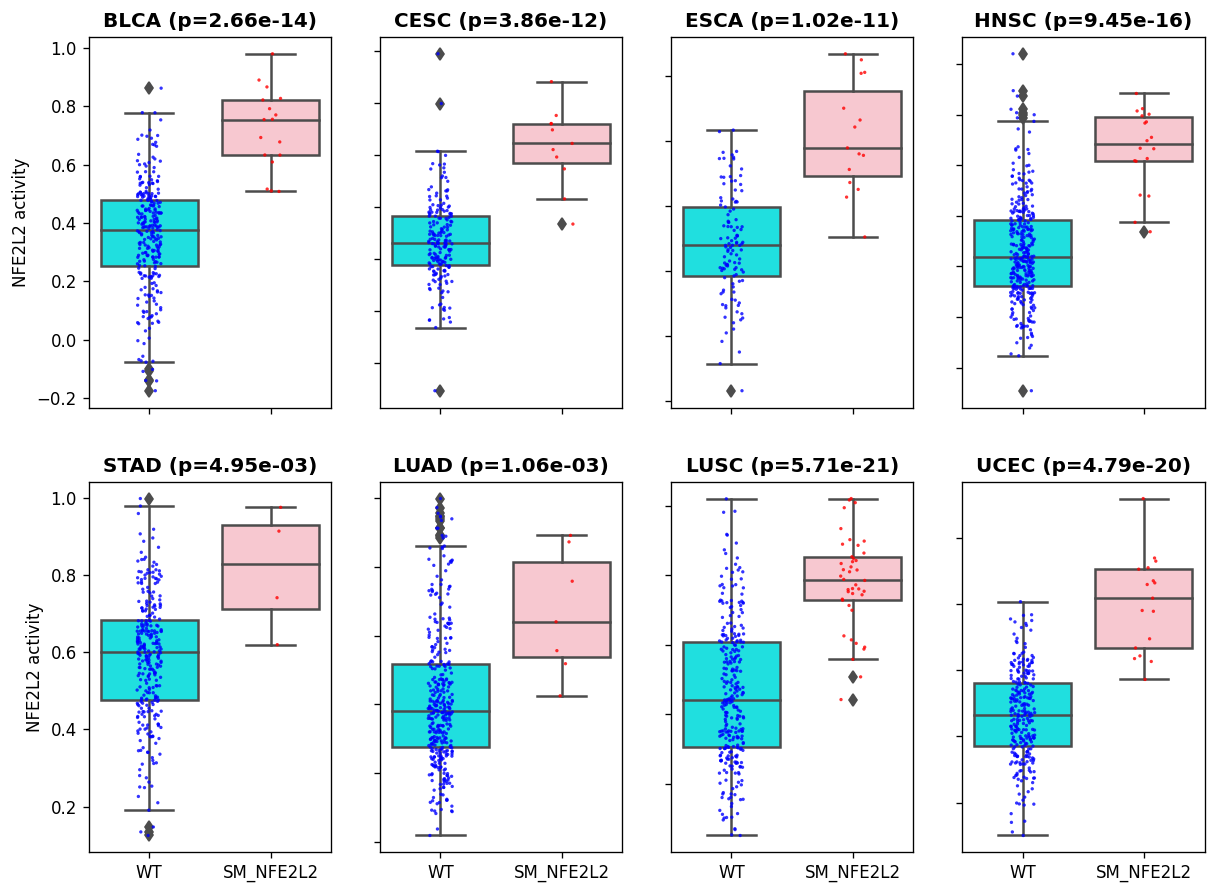

In [11]:
fig, axes = plt.subplots(2, 4, figsize=(12, 9), dpi=120)

gene = 'NFE2L2'
for cancer, axx in zip(['BLCA', 'CESC', 'ESCA', 'HNSC', 'STAD',  'LUAD', 'LUSC', 'UCEC'], axes.flat):
    # plt.figure(figsize=(4, 5), dpi=100)
    wt, sm, _, _ = split_mutants(cancer=cancer, gene=gene)
    _tf = df_tf.loc[set(sm).union(set(wt))][[gene]]
    _tf['is_mutant'] = ['WT' if i in wt else f'SM_{gene}' for i in _tf.index]
    _tf = _tf.sort_values(by='is_mutant', ascending=False)

    sns.boxplot(data=_tf, x='is_mutant', y=gene, palette=['cyan', 'pink'], ax=axx)
    sns.stripplot(data=_tf, x='is_mutant', y=gene, alpha=0.8, size=2, palette=['blue', 'red'], ax=axx)
    pvalue = ttest(_tf[_tf.is_mutant=='WT'][gene].values, _tf[_tf.is_mutant==f'SM_{gene}'][gene].values).pvalue
    if pvalue < 0.05:
        w = 'bold'
    else:
        w = 'light'
        
    axx.set_title(f'{cancer} (p={pvalue:.2e})', fontweight=w)
    axx.set_xlabel('')
    axx.set_ylabel(f'{gene} activity')

for ax in axes.flat:
    ax.label_outer()
plt.show()

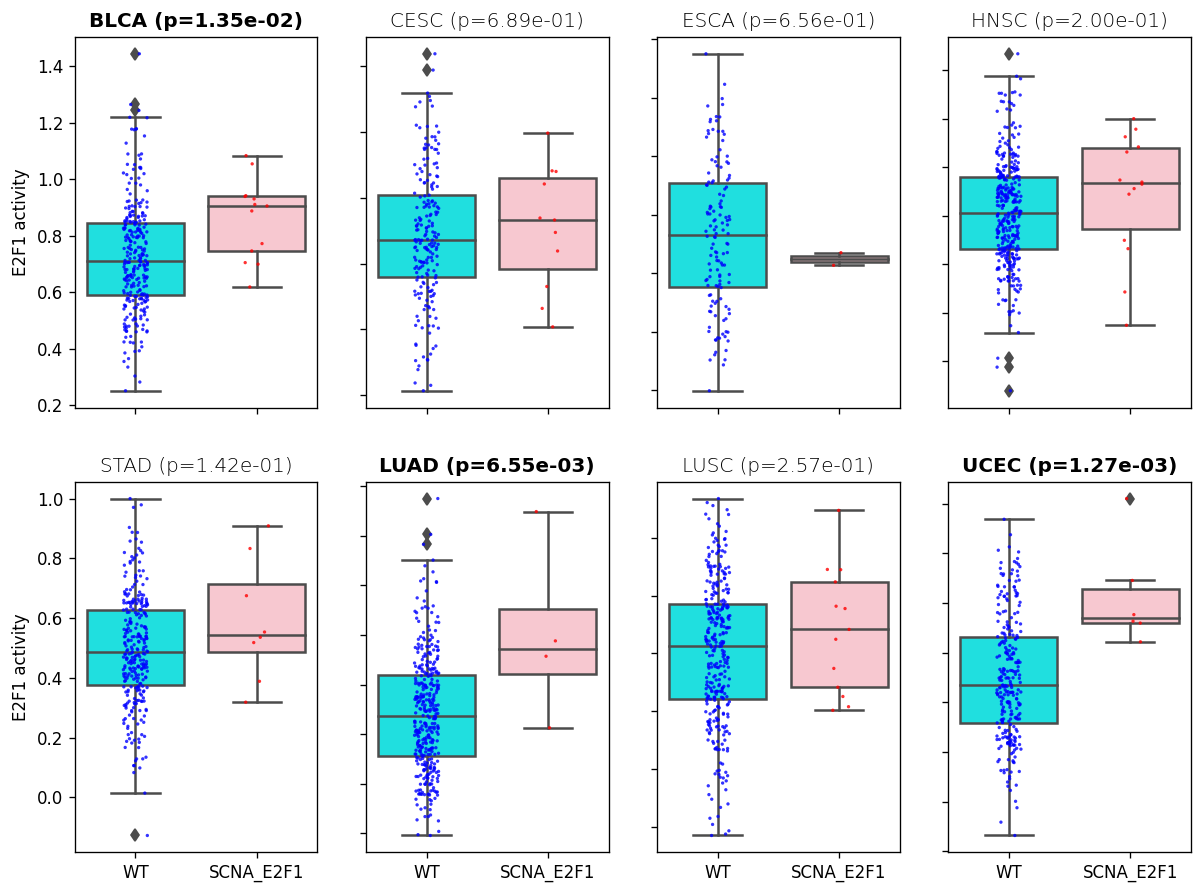

In [12]:
%matplotlib inline
fig, axes = plt.subplots(2, 4, figsize=(12, 9), dpi=120)

gene = 'E2F1'
for cancer, axx in zip(['BLCA', 'CESC', 'ESCA', 'HNSC', 'STAD',  'LUAD', 'LUSC', 'UCEC'], axes.flat):
    # plt.figure(figsize=(4, 5), dpi=100)
    wt, sm, scna, _ = split_mutants(cancer=cancer, gene=gene)
    _tf = df_tf.loc[set(wt).union(set(scna))][[gene]]
    _tf['is_mutant'] = ['WT' if i in wt else f'SCNA_{gene}' for i in _tf.index]
    _tf = _tf.sort_values(by='is_mutant', ascending=False)

    sns.boxplot(data=_tf, x='is_mutant', y=gene, palette=['cyan', 'pink'], ax=axx)
    sns.stripplot(data=_tf, x='is_mutant', y=gene, alpha=0.8, size=2, palette=['blue', 'red'], ax=axx)
    pvalue = ttest(_tf[_tf.is_mutant=='WT'][gene].values, _tf[_tf.is_mutant==f'SCNA_{gene}'][gene].values).pvalue
    if pvalue < 0.05:
        w = 'bold'
    else:
        w = 'light'
        
    axx.set_title(f'{cancer} (p={pvalue:.2e})', fontweight=w)
    axx.set_xlabel('')
    axx.set_ylabel(f'{gene} activity')

# plt.ylabel(f'{gene} activity')
for ax in axes.flat:
    ax.label_outer()
plt.show()

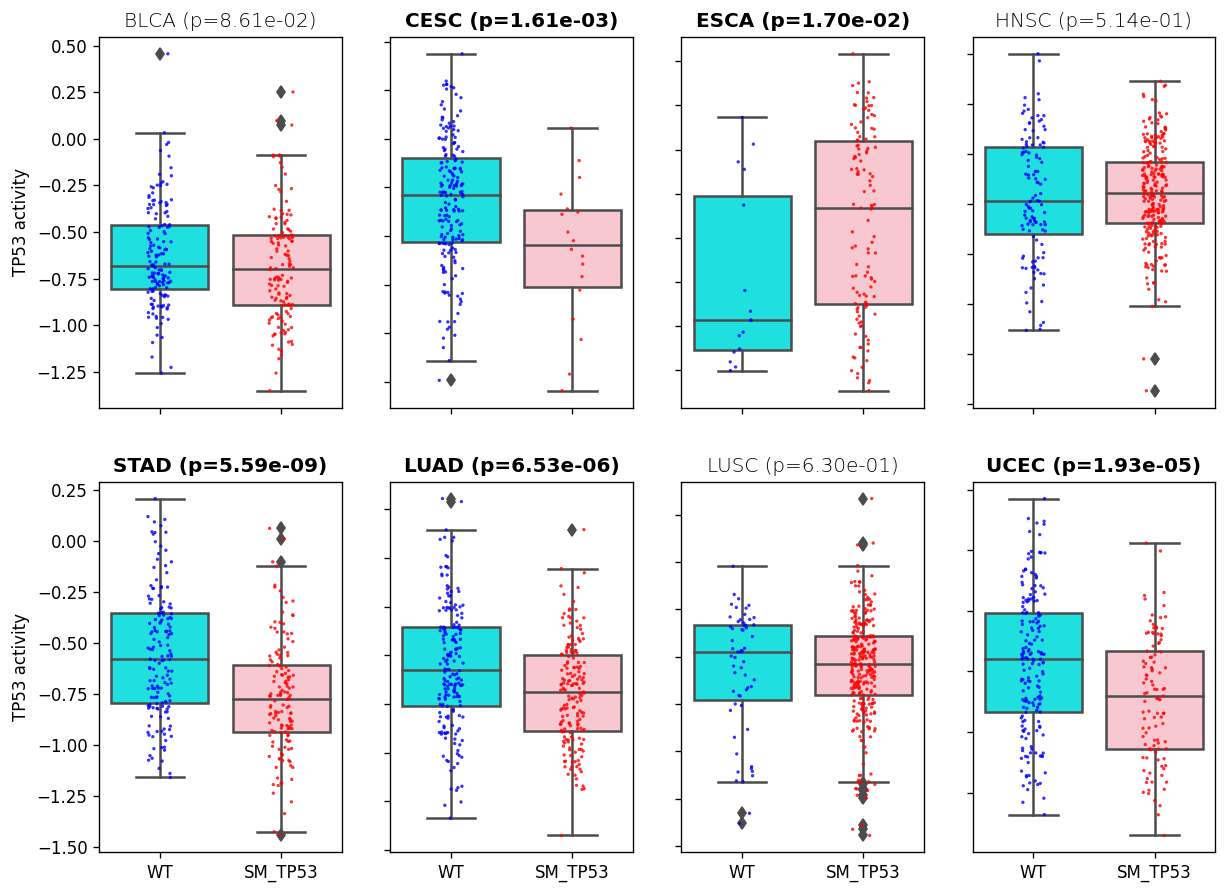

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(12, 9), dpi=120)

gene = 'TP53'
for cancer, axx in zip(['BLCA', 'CESC', 'ESCA', 'HNSC', 'STAD',  'LUAD', 'LUSC', 'UCEC'], axes.flat):
    # plt.figure(figsize=(4, 5), dpi=100)
    wt, sm, _, _ = split_mutants(cancer=cancer, gene=gene)
    _tf = df_tf.loc[set(sm).union(set(wt))][[gene]]
    _tf['is_mutant'] = ['WT' if i in wt else f'SM_{gene}' for i in _tf.index]
    _tf = _tf.sort_values(by='is_mutant', ascending=False)

    sns.boxplot(data=_tf, x='is_mutant', y=gene, palette=['cyan', 'pink'], ax=axx)
    sns.stripplot(data=_tf, x='is_mutant', y=gene, alpha=0.8, size=2, palette=['blue', 'red'], ax=axx)
    pvalue = ttest(_tf[_tf.is_mutant=='WT'][gene].values, _tf[_tf.is_mutant==f'SM_{gene}'][gene].values).pvalue
    if pvalue < 0.05:
        w = 'bold'
    else:
        w = 'light'
        
    axx.set_title(f'{cancer} (p={pvalue:.2e})', fontweight=w)
    axx.set_xlabel('')
    axx.set_ylabel(f'{gene} activity')

# plt.ylabel(f'{gene} activity')
for ax in axes.flat:
    ax.label_outer()
plt.show()